<a href="https://colab.research.google.com/github/lmei33/trial/blob/master/NLP_APIs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset:
https://www.kaggle.com/septa97/100k-courseras-course-reviews-dataset

# AWS


In [0]:
! pip install aws

## Load AWS API Keys

`cp ~/.aws/credentials /Users/myname/Google\ Drive/awsml/`

### Mount GDrive


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
import os;os.listdir("/content/gdrive/My Drive/awsml")

['credentials.txt', 'config.txt']

### Install Boto

In [0]:
!pip -q install boto3

### Create API Config

In [0]:
!mkdir -p ~/.aws &&\
  cp /content/gdrive/My\ Drive/awsml/credentials.txt ~/.aws/credentials

### Test Comprehend API Call

In [0]:
import boto3
comprehend = boto3.client(service_name='comprehend', region_name="us-east-1")
text = "There is smoke in San Francisco and it makes me angry"
comprehend.detect_sentiment(Text=text, LanguageCode='en')

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
   'content-length': '164',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 13 Mar 2019 18:17:04 GMT',
   'x-amzn-requestid': '3434e298-45bc-11e9-a302-4b1d8b8a9dca'},
  'HTTPStatusCode': 200,
  'RequestId': '3434e298-45bc-11e9-a302-4b1d8b8a9dca',
  'RetryAttempts': 0},
 'Sentiment': 'NEGATIVE',
 'SentimentScore': {'Mixed': 0.010819978080689907,
  'Negative': 0.9212133288383484,
  'Neutral': 0.06721948087215424,
  'Positive': 0.0007472822326235473}}

## Ingest

In [0]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/lmei33/Miscellaneous/master/reviews.csv")
df.head()

,Id,Review,Label
0,0,good and interesting,5
1,1,"This class is very helpful to me. Currently, I...",5
2,2,like!Prof and TAs are helpful and the discussi...,5
3,3,Easy to follow and includes a lot basic and im...,5
4,4,Really nice teacher!I could got the point eazl...,4


In [0]:
# Given the processing time, I'm using part of the dataset
df1 = df.iloc[:10000]

In [0]:
def create_sentiment(row):
    """Uses AWS Comprehend to Create Sentiments on a DataFrame"""

    try: 
        comprehend = boto3.client(service_name='comprehend', region_name="us-east-1")
        payload = comprehend.detect_sentiment(Text=row, LanguageCode='en')  
        sentiment = payload['Sentiment']
    except Exception:
        print("Size exceeded:  Fail")
        return None
    return sentiment

In [0]:
df1['Sentiment'] = df1['Review'].apply(create_sentiment)
df1.head()

Size exceeded:  Fail
Size exceeded:  Fail


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Id,Review,Label,Sentiment
0,0,good and interesting,5,POSITIVE
1,1,"This class is very helpful to me. Currently, I...",5,POSITIVE
2,2,like!Prof and TAs are helpful and the discussi...,5,POSITIVE
3,3,Easy to follow and includes a lot basic and im...,5,POSITIVE
4,4,Really nice teacher!I could got the point eazl...,4,POSITIVE


# GCP

## Test GCP Credentials

In [0]:
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types

In [0]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/gdrive/My Drive/homeworkai-5958d204220d.json"

In [0]:
text = 'I am delighted'
client = language.LanguageServiceClient()
document = types.Document(
    content=text,
    type=enums.Document.Type.PLAIN_TEXT)

# Detects the sentiment of the text
client.analyze_sentiment(document=document).document_sentiment.score

0.8999999761581421

In [0]:
def create_sentiment_score(row):
    """Uses GCP to Create Sentiments on a DataFrame"""

    try: 
        document = types.Document(content=row, type=enums.Document.Type.PLAIN_TEXT)  
        sentiment = client.analyze_sentiment(document=document).document_sentiment
        sentiment_score = sentiment.score
    except Exception:
        print("Size exceeded:  Fail")
        return None
    return sentiment_score

In [0]:
df1['Sentiment Score'] = df1['Review'].apply(create_sentiment_score)
df1.head()

# EDA

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


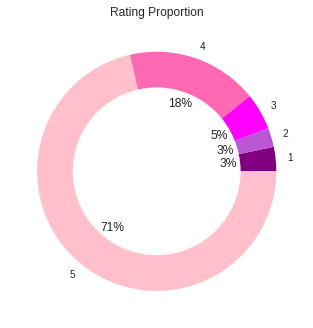

In [0]:
import matplotlib.pyplot as plt
count1 = len(df1[df1['Label'] == 1])
count2 = len(df1[df1['Label'] == 2])
count3 = len(df1[df1['Label'] == 3])
count4 = len(df1[df1['Label'] == 4])
count5 = len(df1[df1['Label'] == 5])
# create data
names='1', '2','3','4','5',
size=[count1,count2,count3,count4,count5]
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['purple','mediumorchid','magenta','hotpink','pink'],autopct='%1.0f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
ax = plt.axes()
ax.set_title("Rating Proportion")
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


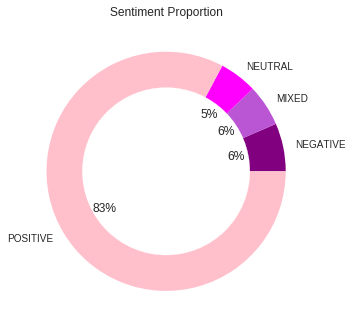

In [0]:
NEGATIVE = len(df1[df1['Sentiment'] == 'NEGATIVE'])
MIXED = len(df1[df1['Sentiment'] == 'MIXED'])
NEUTRAL = len(df1[df1['Sentiment'] == 'NEUTRAL'])
POSITIVE = len(df1[df1['Sentiment'] == 'POSITIVE'])
# create data
names='NEGATIVE','MIXED','NEUTRAL','POSITIVE',
size=[NEGATIVE,MIXED,NEUTRAL,POSITIVE]
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['purple','mediumorchid','magenta','pink'],autopct='%1.0f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
ax = plt.axes()
ax.set_title("Sentiment Proportion")
plt.show()

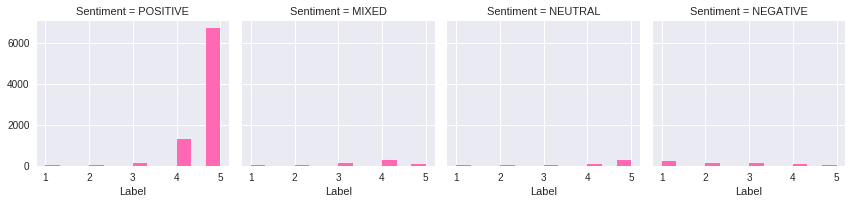

In [0]:
import seaborn as sns
import numpy as np

g = sns.FacetGrid(df1, col="Sentiment", margin_titles=True)
bins = np.linspace(1, 5, 13)
g.map(plt.hist, "Label", color="hotpink", bins=bins)

In [0]:
!pip -q install nltk
nltk.download('stopwords')
!pip -q install wordcloud

In [0]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS

In [0]:
def remove_punc_stopword(text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    remove_punc = [word for word in text if word not in string.punctuation]
    remove_punc = ''.join(remove_punc)
    return [word.lower() for word in remove_punc.split() if word.lower() not in stopwords.words('english')]

In [0]:
coursera_sentiment_text = df1.copy()
coursera_sentiment_text['Review'] = coursera_sentiment_text['Review'].apply(remove_punc_stopword)
coursera_sentiment_text = coursera_sentiment_text[coursera_sentiment_text['Sentiment'] == 'NEGATIVE']['Review'].values

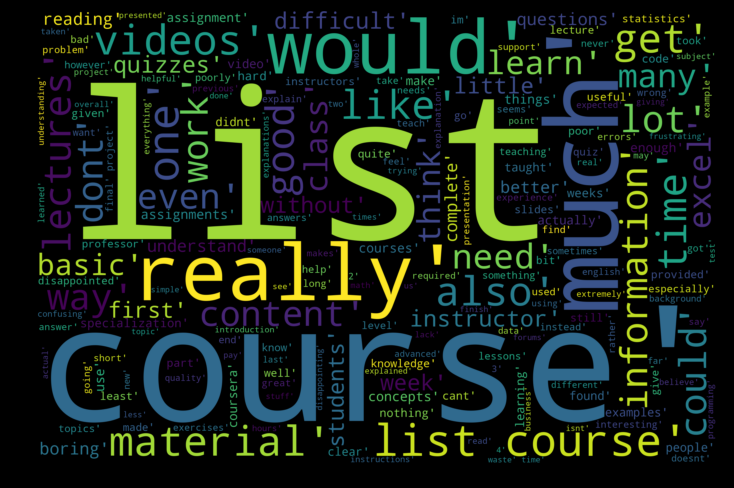

In [0]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    stopwords = STOPWORDS).generate(str(coursera_sentiment_text))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


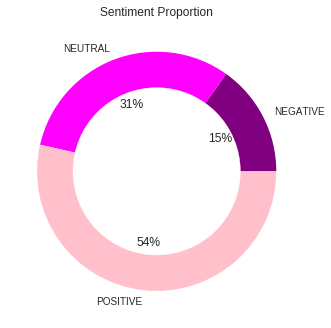

In [0]:
NEGATIVE = len(df1[df1['Sentiment Score'] <= 0.3])
NEUTRAL = len(df1[(df1['Sentiment Score'] > 0.3)&(df2['Sentiment Score'] <0.7)])
POSITIVE = len(df1[df1['Sentiment Score'] >= 0.7])
# create data
names='NEGATIVE','NEUTRAL','POSITIVE',
size=[NEGATIVE,NEUTRAL,POSITIVE]
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['purple','magenta','pink'],autopct='%1.0f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
ax = plt.axes()
ax.set_title("Sentiment Proportion")
plt.show()

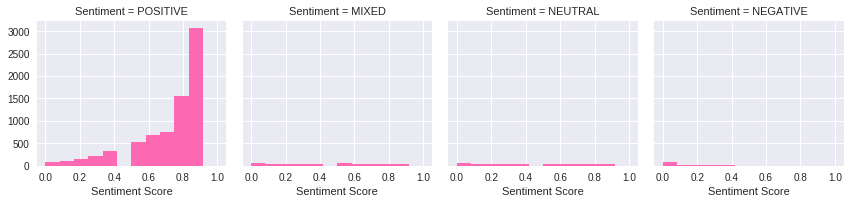

In [0]:
g = sns.FacetGrid(df1, col="Sentiment", margin_titles=True)
bins = np.linspace(0, 1, 13)
g.map(plt.hist, "Sentiment Score", color="hotpink", bins=bins)

In [0]:
coursera_sentiment_text = df1.copy()
coursera_sentiment_text['Review'] = coursera_sentiment_text['Review'].apply(remove_punc_stopword)
coursera_sentiment_text = coursera_sentiment_text[coursera_sentiment_text['Sentiment Score'] <= 0.3]['Review'].values

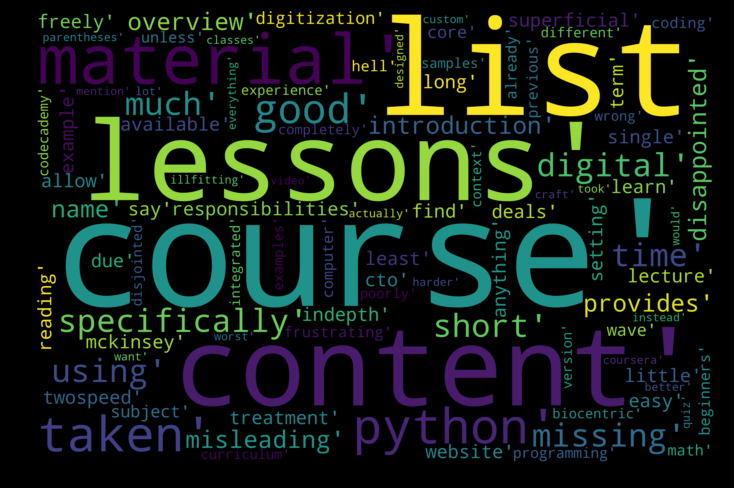

In [0]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    stopwords = STOPWORDS).generate(str(coursera_sentiment_text))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

# Conclusion